<a href="https://colab.research.google.com/github/anshika-pathakk/ML-Lab_Experiments/blob/main/Exp2/linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
from google.colab import files
uploaded = files.upload()


Saving california_housing_train.csv to california_housing_train.csv
Saving california_housing_test.csv to california_housing_test.csv


In [10]:

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression


In [12]:
#A) DATA PROCESSING:

import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np

# 1) Load train & test data
train = pd.read_csv("california_housing_train.csv")
test = pd.read_csv("california_housing_test.csv")

print("Train shape:", train.shape)
print("Test shape:", test.shape)
X_train = train.drop(columns=['median_house_value'])
y_train = train['median_house_value']

X_test = test.drop(columns=['median_house_value'])
y_test = test['median_house_value']

# 2) Standardize features (zero mean, unit variance)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)


# 3) Add intercept (bias) column of ones
X_train_scaled.insert(0, 'intercept', 1)
X_test_scaled.insert(0, 'intercept', 1)

print("Processed Train Features Shape:", X_train_scaled.shape)
print("Processed Test Features Shape:", X_test_scaled.shape)


Train shape: (17000, 9)
Test shape: (3000, 9)
Processed Train Features Shape: (17000, 9)
Processed Test Features Shape: (3000, 9)


In [13]:
#B) IMPLEMENT NORMAL EQUATION:
X = X_train_scaled.values
y = y_train.values.reshape(-1, 1)

theta = np.linalg.pinv(X) @ y
y_pred = X_test_scaled.values @ theta




In [14]:
#C) Implement Batch Gradient Descent (iterative):


def batch_gradient_descent(X, y, alpha=0.01, num_iters=1000, tol=None):
    n, d = X.shape
    theta = np.zeros((d, 1))
    losses = []

    for i in range(num_iters):
        y_pred = X @ theta
        error = y_pred - y
        loss = (1/(2*n)) * np.sum(error**2)
        losses.append(loss)

        grad = (1/n) * (X.T @ error)
        theta -= alpha * grad

        if tol and i > 0 and abs(losses[-2] - losses[-1]) < tol:
            break

    return theta, losses

X = X_train_scaled.values
y = y_train.values.reshape(-1, 1)

theta_gd, losses = batch_gradient_descent(X, y, alpha=0.01, num_iters=1000, tol=1e-6)


In [15]:
#D) Comparisons with scikit-learn

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

y_pred_gd = X_test_scaled.values @ theta_gd
mse_gd = mean_squared_error(y_test, y_pred_gd)
r2_gd = r2_score(y_test, y_pred_gd)

lr = LinearRegression(fit_intercept=False)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print("Gradient Descent -> MSE:", mse_gd, "R²:", r2_gd)
print("Sklearn LinearRegression -> MSE:", mse_lr, "R²:", r2_lr)


Gradient Descent -> MSE: 5149828415.410274 R²: 0.5974116946603373
Sklearn LinearRegression -> MSE: 4867205486.928866 R²: 0.6195057678311999


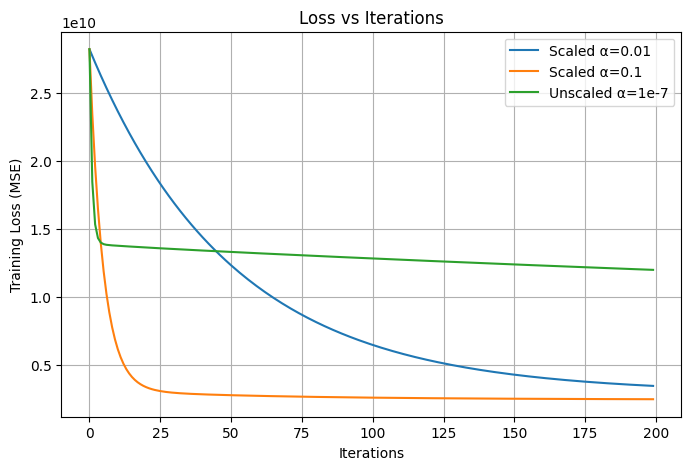

In [16]:
#E) Visualizations

#1) Loss vs Iterations (different learning rates + scaling effect)
import matplotlib.pyplot as plt

def run_gd(alpha, X, y, label):
    _, losses = batch_gradient_descent(X, y, alpha=alpha, num_iters=200)
    plt.plot(losses, label=label)

plt.figure(figsize=(8,5))

# scaled
run_gd(0.01, X_train_scaled.values, y_train.values.reshape(-1,1), "Scaled α=0.01")
run_gd(0.1, X_train_scaled.values, y_train.values.reshape(-1,1), "Scaled α=0.1")

# unscaled
run_gd(0.0000001, X_train.values, y_train.values.reshape(-1,1), "Unscaled α=1e-7")

plt.xlabel("Iterations")
plt.ylabel("Training Loss (MSE)")
plt.title("Loss vs Iterations")
plt.legend()
plt.grid(True)
plt.savefig("loss_vs_iterations.png", dpi=300)
plt.show()


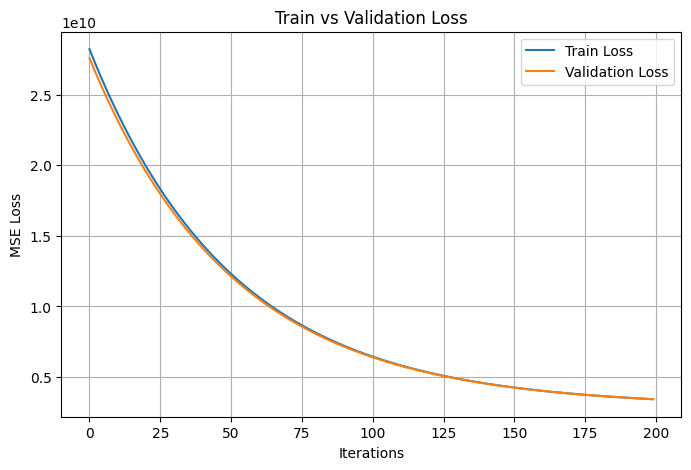

In [17]:
#2) Validation Loss vs Iterations

def batch_gd_with_val(X_train, y_train, X_val, y_val, alpha=0.01, num_iters=200):
    n, d = X_train.shape
    theta = np.zeros((d, 1))
    train_losses, val_losses = [], []

    for i in range(num_iters):
        y_pred = X_train @ theta
        error = y_pred - y_train
        train_loss = (1/(2*n)) * np.sum(error**2)
        train_losses.append(train_loss)

        val_pred = X_val @ theta
        val_loss = (1/(2*len(y_val))) * np.sum((val_pred - y_val)**2)
        val_losses.append(val_loss)

        grad = (1/n) * (X_train.T @ error)
        theta -= alpha * grad

    return theta, train_losses, val_losses

theta_val, train_losses, val_losses = batch_gd_with_val(
    X_train_scaled.values, y_train.values.reshape(-1,1),
    X_test_scaled.values, y_test.values.reshape(-1,1),
    alpha=0.01, num_iters=200
)

plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Iterations")
plt.ylabel("MSE Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.grid(True)
plt.savefig("train_val_loss.png", dpi=300)
plt.show()


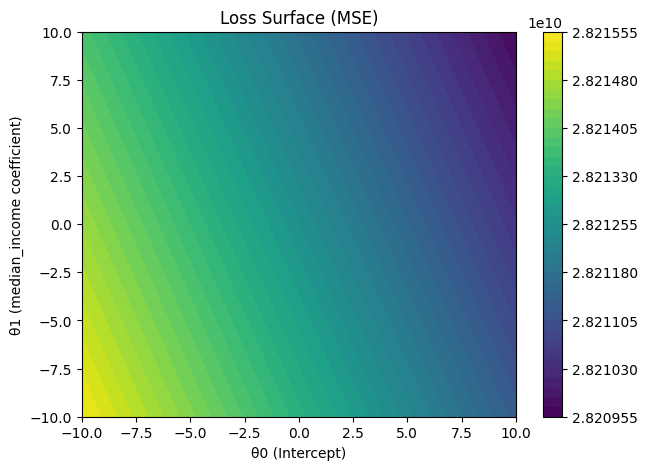

In [18]:
#3) Gradient/Loss Surface Visualization

# Take only 1 feature + intercept for visualization
X_vis = X_train_scaled[['intercept', 'median_income']].values
y_vis = y_train.values.reshape(-1,1)

theta0_vals = np.linspace(-10, 10, 100)
theta1_vals = np.linspace(-10, 10, 100)
J_vals = np.zeros((len(theta0_vals), len(theta1_vals)))

for i, t0 in enumerate(theta0_vals):
    for j, t1 in enumerate(theta1_vals):
        theta_try = np.array([[t0],[t1]])
        errors = X_vis @ theta_try - y_vis
        J_vals[i,j] = (1/(2*len(y_vis))) * np.sum(errors**2)

T0, T1 = np.meshgrid(theta0_vals, theta1_vals)

plt.figure(figsize=(7,5))
cp = plt.contourf(T0, T1, J_vals.T, 50, cmap='viridis')
plt.colorbar(cp)
plt.xlabel("θ0 (Intercept)")
plt.ylabel("θ1 (median_income coefficient)")
plt.title("Loss Surface (MSE)")
plt.savefig("loss_surface.png", dpi=300)
plt.show()


In [20]:
#F) Evaluation metrics

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import pandas as pd

def evaluate_model(theta, X_test, y_test):
    y_pred = X_test @ theta
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    return mse, rmse, r2, mae

# Prepare arrays
X_train_arr = X_train_scaled.values
y_train_arr = y_train.values.reshape(-1,1)
X_test_arr = X_test_scaled.values
y_test_arr = y_test.values.reshape(-1,1)

# --- Normal Equation ---
theta_ne = np.linalg.pinv(X_train_arr) @ y_train_arr
mse_ne, rmse_ne, r2_ne, mae_ne = evaluate_model(theta_ne, X_test_arr, y_test_arr)

# --- Gradient Descent ---
theta_gd, _ = batch_gradient_descent(X_train_arr, y_train_arr, alpha=0.01, num_iters=500)
mse_gd, rmse_gd, r2_gd, mae_gd = evaluate_model(theta_gd, X_test_arr, y_test_arr)

# --- Sklearn ---
from sklearn.linear_model import LinearRegression
lr = LinearRegression(fit_intercept=False)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
r2_lr = r2_score(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)

# Collect results in a DataFrame
results = pd.DataFrame({
    "MSE": [mse_ne, mse_gd, mse_lr],
    "RMSE": [rmse_ne, rmse_gd, rmse_lr],
    "R2": [r2_ne, r2_gd, r2_lr],
    "MAE": [mae_ne, mae_gd, mae_lr]
}, index=["Normal Equation", "Gradient Descent", "Sklearn LinearRegression"])

print(results)



                                   MSE          RMSE        R2           MAE
Normal Equation           4.867205e+09  69765.360222  0.619506  50352.228258
Gradient Descent          5.499150e+09  74156.254531  0.570103  53891.312522
Sklearn LinearRegression  4.867205e+09  69765.360222  0.619506  50352.228258


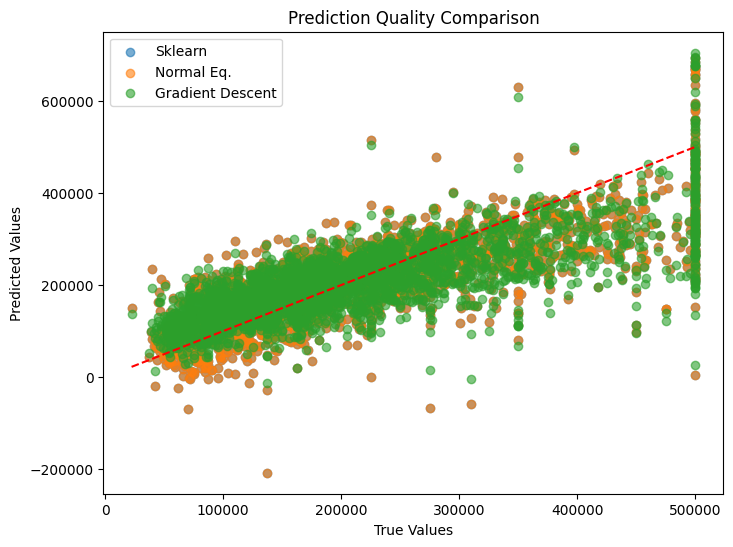

In [26]:
import matplotlib.pyplot as plt

# Predictions from each model
y_pred_normal = X_test_arr @ theta_ne
y_pred_gd = X_test_arr @ theta_gd
y_pred_sklearn = y_pred_lr  # already computed

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_sklearn, label="Sklearn", alpha=0.6)
plt.scatter(y_test, y_pred_normal, label="Normal Eq.", alpha=0.6)
plt.scatter(y_test, y_pred_gd, label="Gradient Descent", alpha=0.6)

# Ideal line
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Prediction Quality Comparison")
plt.legend()
plt.show()
